In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat, savemat
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from time import time
%matplotlib notebook

In [2]:
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/positive_cropped.mat"
mal_dict = loadmat(path)
infected = mal_dict['stack']
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/negative_cropped.mat"
wmal_dict = loadmat(path)
normal = wmal_dict['stack']
infected = np.moveaxis(infected, -1, 0)
normal = np.moveaxis(normal, -1, 0)

infected_train, infected_test = train_test_split(infected, test_size = 0.2)
normal_train, normal_test = train_test_split(normal, test_size = 0.2)
data = (infected_train, infected_test, normal_train, normal_test)

In [3]:
add_noise = True
pixel_well_depth = 20000
batch_size = 32
numcategories = 2
image_dim = 28
numchannel = 3

In [4]:
def to_one_hot(y,numcategories = 2):
    y_ = np.zeros((y.size,numcategories))
    y_[np.arange(y.size),y]=1
    return y_

In [5]:
def get_feed_dict_superposition(data, n = 0, training=True):
    # data is the output of load_data_malaria
    # n+1 is the number of images summed, where one is malaria-infected
    # intensity_scale: tune this value so that the detector doesn't saturate
    # training specifies whether to generate from the training data or validation data
    # returns a feed_dict for training (or validation)
    intensity_scale = 1/(n+1)
    X1train, X1val, X0train, X0val = data
    
    if training:
        X0 = X0train
        X1 = X1train
        #X0 = np.mean(X0, 3)[:, :, :, None]  # keep color channel for CNN
        #X1 = np.mean(X1, 3)[:, :, :, None]
    else:
        X0 = X0val
        X1 = X1val
        #X0 = np.mean(X0, 3)[:, :, :, None]  # keep color channel for CNN
        #X1 = np.mean(X1, 3)[:, :, :, None]
    
    s0 = X0.shape
    s1 = X1.shape
    
    # make half of the batch no malaria, half with malaria
    inds0 = np.random.choice(s0[0],size=batch_size*(n+1)-batch_size//2) #for the non-malaria
    inds1 = np.random.choice(s1[0],size=batch_size//2) #for the malaria; only 1 malaria per stack; for half of the batch
    
    # examples for no malaria in stack
    X0stack = X0[inds0[:batch_size//2*(n+1)]].reshape(batch_size//2,n+1,s0[1],s0[2],s0[3])
    X0stack = X0stack.sum(1) #the superpositioned image
    
    # examples for one malaria in stack
    X1stack0 = X0[inds0[batch_size//2*(n+1):]].reshape(batch_size//2,n,s0[1],s0[2],s0[3]) #from the nonmalaria set
    X1stack1 = X1[inds1]
    X1stack = X1stack0.sum(1) + X1stack1
    
    # stack them all together
    Xbatch = np.concatenate([X0stack,X1stack],axis=0)*intensity_scale
    if add_noise:
        Xbatch += np.random.normal(loc=0, scale=np.sqrt(Xbatch*(1-1/(n+1)/numchannel)*256/pixel_well_depth))
    Xbatch = np.minimum(Xbatch,255).astype(np.uint8).astype(np.float32) # threshold and discretize to 8-bit
    ybatch = np.concatenate([np.zeros(batch_size//2,dtype=np.int32),np.ones(batch_size//2,dtype=np.int32)])
    ybatch = to_one_hot(ybatch)
    
    return {X:Xbatch, y:ybatch}

In [6]:
def pass_through_validation(rawdata, n, sess, numbatches, use_random_seed=True):
    #there's no longer a fixed validation set: generate on the fly
    if use_random_seed:
        np.random.seed(0)
    acc = 0
    for i in range(numbatches):
        feed = get_feed_dict_superposition(rawdata, n=n, training=False)
        acc += sess.run(accuracy, feed_dict=feed)
    return acc/numbatches

In [7]:
def CNN2(net,labels,numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net #return net to examine accuracy

In [8]:
acc = list()
fulls = time()
for n in range(15):
    tf.reset_default_graph() 
    sess = tf.Session()
    X = tf.placeholder(dtype=tf.float32, name='data', shape=(batch_size, image_dim, image_dim, numchannel))
    y = tf.placeholder(dtype=tf.int32, name='labels', shape=(batch_size, numcategories))
    pred = CNN2(X, y, 2)  # add batch dim
    loss = tf.losses.softmax_cross_entropy(logits=pred, onehot_labels=y)
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
    prediction = tf.argmax(pred,1)
    truth = tf.argmax(y,1)
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction,truth)))
    
    Accuracy = list()
    for runs in range (10):
        sess.run(tf.global_variables_initializer())
        train_losses = list()
        val_losses = list()
        start=time()
        for i in range(251):
            feed = get_feed_dict_superposition(data, n = n, training = True)
            _, tloss = sess.run([train_op, loss], feed_dict = feed)
            train_losses.append(tloss)
            if i%50==0:
                val_losses.append(pass_through_validation(data, n, sess, numbatches=30))
                print("iteration %d; batch classifier loss: %f; batch Validation accuracy: %f; Time passed in this loop: %.2f" % 
                      (i,train_losses[-1],val_losses[-1],time()-start))
        Accuracy.append(val_losses[-1])
    acc.append(Accuracy)
    sess.close()
fulle = time()

iteration 0; batch classifier loss: 1.169355; batch Validation accuracy: 0.500000; Time passed in this loop: 1.73
iteration 50; batch classifier loss: 0.002618; batch Validation accuracy: 0.972917; Time passed in this loop: 2.42
iteration 100; batch classifier loss: 0.000740; batch Validation accuracy: 0.980208; Time passed in this loop: 3.10
iteration 150; batch classifier loss: 0.000247; batch Validation accuracy: 0.985417; Time passed in this loop: 3.78
iteration 200; batch classifier loss: 0.000126; batch Validation accuracy: 0.985417; Time passed in this loop: 4.46
iteration 250; batch classifier loss: 0.000156; batch Validation accuracy: 0.985417; Time passed in this loop: 5.13
iteration 0; batch classifier loss: 1.717130; batch Validation accuracy: 0.500000; Time passed in this loop: 0.18
iteration 50; batch classifier loss: 0.021204; batch Validation accuracy: 0.982292; Time passed in this loop: 0.85
iteration 100; batch classifier loss: 0.002570; batch Validation accuracy: 0.9

iteration 250; batch classifier loss: 0.005950; batch Validation accuracy: 0.980208; Time passed in this loop: 3.88
iteration 0; batch classifier loss: 0.748349; batch Validation accuracy: 0.500000; Time passed in this loop: 0.19
iteration 50; batch classifier loss: 0.029190; batch Validation accuracy: 0.948958; Time passed in this loop: 0.91
iteration 100; batch classifier loss: 0.007197; batch Validation accuracy: 0.955208; Time passed in this loop: 1.64
iteration 150; batch classifier loss: 0.003026; batch Validation accuracy: 0.956250; Time passed in this loop: 2.38
iteration 200; batch classifier loss: 0.002948; batch Validation accuracy: 0.981250; Time passed in this loop: 3.10
iteration 250; batch classifier loss: 0.001222; batch Validation accuracy: 0.978125; Time passed in this loop: 3.83
iteration 0; batch classifier loss: 1.130468; batch Validation accuracy: 0.500000; Time passed in this loop: 0.18
iteration 50; batch classifier loss: 0.027391; batch Validation accuracy: 0.9

iteration 200; batch classifier loss: 0.279541; batch Validation accuracy: 0.972917; Time passed in this loop: 3.16
iteration 250; batch classifier loss: 0.215189; batch Validation accuracy: 0.978125; Time passed in this loop: 3.92
iteration 0; batch classifier loss: 0.833634; batch Validation accuracy: 0.500000; Time passed in this loop: 0.23
iteration 50; batch classifier loss: 0.486965; batch Validation accuracy: 0.904167; Time passed in this loop: 1.01
iteration 100; batch classifier loss: 0.434808; batch Validation accuracy: 0.932292; Time passed in this loop: 1.73
iteration 150; batch classifier loss: 0.339816; batch Validation accuracy: 0.942708; Time passed in this loop: 2.46
iteration 200; batch classifier loss: 0.265572; batch Validation accuracy: 0.962500; Time passed in this loop: 3.21
iteration 250; batch classifier loss: 0.195538; batch Validation accuracy: 0.971875; Time passed in this loop: 3.95
iteration 0; batch classifier loss: 1.625422; batch Validation accuracy: 0.

iteration 150; batch classifier loss: 0.150354; batch Validation accuracy: 0.951042; Time passed in this loop: 2.47
iteration 200; batch classifier loss: 0.126188; batch Validation accuracy: 0.950000; Time passed in this loop: 3.21
iteration 250; batch classifier loss: 0.139989; batch Validation accuracy: 0.938542; Time passed in this loop: 3.96
iteration 0; batch classifier loss: 0.882614; batch Validation accuracy: 0.500000; Time passed in this loop: 0.19
iteration 50; batch classifier loss: 0.327715; batch Validation accuracy: 0.855208; Time passed in this loop: 0.94
iteration 100; batch classifier loss: 0.177609; batch Validation accuracy: 0.920833; Time passed in this loop: 1.73
iteration 150; batch classifier loss: 0.114216; batch Validation accuracy: 0.948958; Time passed in this loop: 2.55
iteration 200; batch classifier loss: 0.116505; batch Validation accuracy: 0.955208; Time passed in this loop: 3.30
iteration 250; batch classifier loss: 0.102865; batch Validation accuracy: 

iteration 100; batch classifier loss: 0.401347; batch Validation accuracy: 0.893750; Time passed in this loop: 1.72
iteration 150; batch classifier loss: 0.163882; batch Validation accuracy: 0.952083; Time passed in this loop: 2.46
iteration 200; batch classifier loss: 0.061388; batch Validation accuracy: 0.957292; Time passed in this loop: 3.22
iteration 250; batch classifier loss: 0.046914; batch Validation accuracy: 0.962500; Time passed in this loop: 3.97
iteration 0; batch classifier loss: 1.507579; batch Validation accuracy: 0.500000; Time passed in this loop: 0.24
iteration 50; batch classifier loss: 0.581149; batch Validation accuracy: 0.833333; Time passed in this loop: 1.00
iteration 100; batch classifier loss: 0.608096; batch Validation accuracy: 0.829167; Time passed in this loop: 1.74
iteration 150; batch classifier loss: 0.445943; batch Validation accuracy: 0.821875; Time passed in this loop: 2.50
iteration 200; batch classifier loss: 0.166693; batch Validation accuracy: 

iteration 50; batch classifier loss: 0.476825; batch Validation accuracy: 0.836458; Time passed in this loop: 0.97
iteration 100; batch classifier loss: 0.253398; batch Validation accuracy: 0.865625; Time passed in this loop: 1.78
iteration 150; batch classifier loss: 0.229070; batch Validation accuracy: 0.904167; Time passed in this loop: 2.56
iteration 200; batch classifier loss: 0.240093; batch Validation accuracy: 0.760417; Time passed in this loop: 3.35
iteration 250; batch classifier loss: 0.196573; batch Validation accuracy: 0.916667; Time passed in this loop: 4.14
iteration 0; batch classifier loss: 1.281522; batch Validation accuracy: 0.500000; Time passed in this loop: 0.44
iteration 50; batch classifier loss: 0.609721; batch Validation accuracy: 0.726042; Time passed in this loop: 1.22
iteration 100; batch classifier loss: 0.484282; batch Validation accuracy: 0.859375; Time passed in this loop: 1.97
iteration 150; batch classifier loss: 0.401848; batch Validation accuracy: 0

iteration 0; batch classifier loss: 2.647835; batch Validation accuracy: 0.500000; Time passed in this loop: 0.21
iteration 50; batch classifier loss: 0.496067; batch Validation accuracy: 0.766667; Time passed in this loop: 0.99
iteration 100; batch classifier loss: 0.358472; batch Validation accuracy: 0.818750; Time passed in this loop: 1.78
iteration 150; batch classifier loss: 0.152236; batch Validation accuracy: 0.878125; Time passed in this loop: 2.57
iteration 200; batch classifier loss: 0.122145; batch Validation accuracy: 0.912500; Time passed in this loop: 3.36
iteration 250; batch classifier loss: 0.086862; batch Validation accuracy: 0.934375; Time passed in this loop: 4.15
iteration 0; batch classifier loss: 1.129884; batch Validation accuracy: 0.500000; Time passed in this loop: 0.22
iteration 50; batch classifier loss: 0.546912; batch Validation accuracy: 0.769792; Time passed in this loop: 0.99
iteration 100; batch classifier loss: 0.217177; batch Validation accuracy: 0.8

iteration 250; batch classifier loss: 0.277664; batch Validation accuracy: 0.916667; Time passed in this loop: 4.29
iteration 0; batch classifier loss: 0.771618; batch Validation accuracy: 0.500000; Time passed in this loop: 0.22
iteration 50; batch classifier loss: 0.607201; batch Validation accuracy: 0.780208; Time passed in this loop: 1.03
iteration 100; batch classifier loss: 0.388562; batch Validation accuracy: 0.828125; Time passed in this loop: 1.84
iteration 150; batch classifier loss: 0.243374; batch Validation accuracy: 0.934375; Time passed in this loop: 2.65
iteration 200; batch classifier loss: 0.256272; batch Validation accuracy: 0.943750; Time passed in this loop: 3.44
iteration 250; batch classifier loss: 0.298241; batch Validation accuracy: 0.945833; Time passed in this loop: 4.28
iteration 0; batch classifier loss: 1.140532; batch Validation accuracy: 0.500000; Time passed in this loop: 0.23
iteration 50; batch classifier loss: 0.558081; batch Validation accuracy: 0.8

iteration 200; batch classifier loss: 0.134700; batch Validation accuracy: 0.890625; Time passed in this loop: 3.48
iteration 250; batch classifier loss: 0.105638; batch Validation accuracy: 0.931250; Time passed in this loop: 4.32
iteration 0; batch classifier loss: 0.755345; batch Validation accuracy: 0.500000; Time passed in this loop: 0.23
iteration 50; batch classifier loss: 0.554044; batch Validation accuracy: 0.758333; Time passed in this loop: 1.04
iteration 100; batch classifier loss: 0.397232; batch Validation accuracy: 0.800000; Time passed in this loop: 1.87
iteration 150; batch classifier loss: 0.259706; batch Validation accuracy: 0.894792; Time passed in this loop: 2.72
iteration 200; batch classifier loss: 0.149788; batch Validation accuracy: 0.890625; Time passed in this loop: 3.55
iteration 250; batch classifier loss: 0.452049; batch Validation accuracy: 0.790625; Time passed in this loop: 4.36
iteration 0; batch classifier loss: 0.644142; batch Validation accuracy: 0.

iteration 150; batch classifier loss: 0.430320; batch Validation accuracy: 0.770833; Time passed in this loop: 2.76
iteration 200; batch classifier loss: 0.308742; batch Validation accuracy: 0.755208; Time passed in this loop: 3.63
iteration 250; batch classifier loss: 0.382658; batch Validation accuracy: 0.785417; Time passed in this loop: 4.45
iteration 0; batch classifier loss: 1.162723; batch Validation accuracy: 0.500000; Time passed in this loop: 0.24
iteration 50; batch classifier loss: 0.601269; batch Validation accuracy: 0.625000; Time passed in this loop: 1.07
iteration 100; batch classifier loss: 0.483979; batch Validation accuracy: 0.735417; Time passed in this loop: 1.90
iteration 150; batch classifier loss: 0.385516; batch Validation accuracy: 0.728125; Time passed in this loop: 2.73
iteration 200; batch classifier loss: 0.384864; batch Validation accuracy: 0.771875; Time passed in this loop: 3.56
iteration 250; batch classifier loss: 0.547155; batch Validation accuracy: 

iteration 100; batch classifier loss: 0.583098; batch Validation accuracy: 0.798958; Time passed in this loop: 1.90
iteration 150; batch classifier loss: 0.540638; batch Validation accuracy: 0.789583; Time passed in this loop: 2.73
iteration 200; batch classifier loss: 0.336097; batch Validation accuracy: 0.817708; Time passed in this loop: 3.57
iteration 250; batch classifier loss: 0.404376; batch Validation accuracy: 0.830208; Time passed in this loop: 4.43
iteration 0; batch classifier loss: 0.673516; batch Validation accuracy: 0.500000; Time passed in this loop: 0.23
iteration 50; batch classifier loss: 0.666654; batch Validation accuracy: 0.506250; Time passed in this loop: 1.06
iteration 100; batch classifier loss: 0.604676; batch Validation accuracy: 0.800000; Time passed in this loop: 1.93
iteration 150; batch classifier loss: 0.508691; batch Validation accuracy: 0.690625; Time passed in this loop: 2.78
iteration 200; batch classifier loss: 0.355764; batch Validation accuracy: 

iteration 50; batch classifier loss: 0.663520; batch Validation accuracy: 0.628125; Time passed in this loop: 1.35
iteration 100; batch classifier loss: 0.575471; batch Validation accuracy: 0.752083; Time passed in this loop: 2.21
iteration 150; batch classifier loss: 0.483886; batch Validation accuracy: 0.793750; Time passed in this loop: 3.07
iteration 200; batch classifier loss: 0.387114; batch Validation accuracy: 0.778125; Time passed in this loop: 3.94
iteration 250; batch classifier loss: 0.399904; batch Validation accuracy: 0.822917; Time passed in this loop: 4.81
iteration 0; batch classifier loss: 0.874673; batch Validation accuracy: 0.500000; Time passed in this loop: 0.25
iteration 50; batch classifier loss: 0.651981; batch Validation accuracy: 0.671875; Time passed in this loop: 1.12
iteration 100; batch classifier loss: 0.561088; batch Validation accuracy: 0.713542; Time passed in this loop: 1.97
iteration 150; batch classifier loss: 0.422529; batch Validation accuracy: 0

iteration 0; batch classifier loss: 0.714343; batch Validation accuracy: 0.500000; Time passed in this loop: 0.26
iteration 50; batch classifier loss: 0.666200; batch Validation accuracy: 0.540625; Time passed in this loop: 1.12
iteration 100; batch classifier loss: 0.516534; batch Validation accuracy: 0.750000; Time passed in this loop: 1.98
iteration 150; batch classifier loss: 0.227317; batch Validation accuracy: 0.834375; Time passed in this loop: 2.85
iteration 200; batch classifier loss: 0.158197; batch Validation accuracy: 0.839583; Time passed in this loop: 3.71
iteration 250; batch classifier loss: 0.209435; batch Validation accuracy: 0.878125; Time passed in this loop: 4.57
iteration 0; batch classifier loss: 0.767530; batch Validation accuracy: 0.500000; Time passed in this loop: 0.26
iteration 50; batch classifier loss: 0.662661; batch Validation accuracy: 0.596875; Time passed in this loop: 1.13
iteration 100; batch classifier loss: 0.554183; batch Validation accuracy: 0.7

In [9]:
acc

[[0.9854166666666667,
  0.9854166666666667,
  0.9854166666666667,
  0.9854166666666667,
  0.9854166666666667,
  0.9854166666666667,
  0.9854166666666667,
  0.984375,
  0.9854166666666667,
  0.9854166666666667],
 [0.9822916666666667,
  0.9802083333333333,
  0.978125,
  0.98125,
  0.9822916666666667,
  0.984375,
  0.98125,
  0.9760416666666667,
  0.98125,
  0.9729166666666667],
 [0.975,
  0.971875,
  0.9677083333333333,
  0.978125,
  0.971875,
  0.9677083333333333,
  0.9822916666666667,
  0.9635416666666666,
  0.975,
  0.9666666666666667],
 [0.9395833333333333,
  0.9510416666666667,
  0.9458333333333333,
  0.928125,
  0.9510416666666667,
  0.9385416666666667,
  0.9572916666666667,
  0.9635416666666666,
  0.9322916666666666,
  0.9489583333333333],
 [0.9625,
  0.9614583333333333,
  0.96875,
  0.9552083333333333,
  0.928125,
  0.953125,
  0.9583333333333334,
  0.9625,
  0.890625,
  0.9520833333333333],
 [0.9302083333333333,
  0.8979166666666667,
  0.85,
  0.9260416666666667,
  0.915625,
  0

In [10]:
fulle-fulls

687.6176781654358

Text(0, 0.5, 'accuracy')

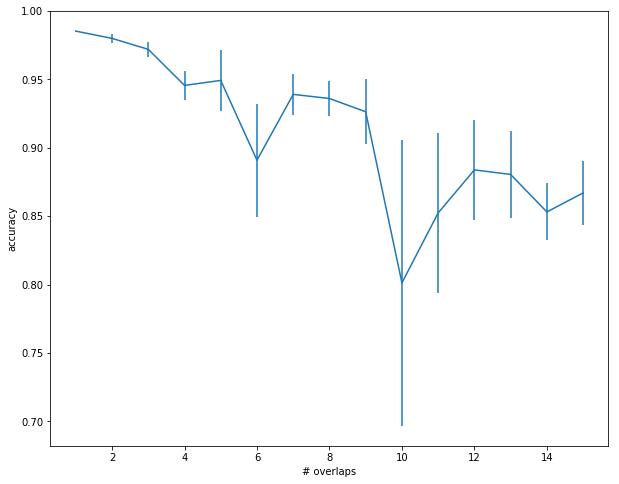

In [11]:
std = np.std(acc, axis=1)
mean = np.mean(acc, axis=1)
plt.figure(figsize=(10,8))
plt.errorbar(np.arange(1,16), mean, yerr=[std, std])
plt.xlabel("# overlaps")
plt.ylabel("accuracy")

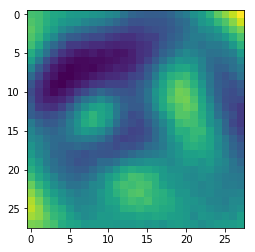

In [12]:
feed = get_feed_dict_superposition(data, n = 0, training = True)
plt.imshow(feed[X][20][:,:,0].astype(np.uint8))